In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn import metrics

df = pd.read_csv('data/fake_data.csv')

In [47]:
X = df[['AreaSQM', 'Number of Floors', 'Bedrooms', 'Carport', 'Yard']]
y = df[['PHP(1.00)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [48]:
# Create models
linear_regression = LinearRegression()
xgb_regressor = xgb.XGBRegressor()
random_forest = RandomForestRegressor()

# Train the models using the training sets
linear_regression.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# Make predictions using the testing set
linear_regression_predict = linear_regression.predict(X_test)
xgb_regressor_predict = xgb_regressor.predict(X_test)
random_forest_predict = random_forest.predict(X_test)

E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
E:\Source\python\datascience\venv\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_fl

In [54]:
print('Linear Regression RMSE: %.2f' % mean_squared_error(y_test, linear_regression_predict, squared=False))
print('XGB Regressor RMSE: %.2f' % mean_squared_error(y_test, xgb_regressor_predict, squared=False))
print('Random Forest RMSE: %.2f' % mean_squared_error(y_test, random_forest_predict, squared=False))

# R squared score for each prediction
print('Linear Regression R^2: %.2f' % metrics.r2_score(y_test, linear_regression_predict))
print('XGB Regressor R^2: %.2f' % metrics.r2_score(y_test, xgb_regressor_predict))
print('Random Forest R^2: %.2f' % metrics.r2_score(y_test, random_forest_predict))

Linear Regression RMSE: 0.57
XGB Regressor RMSE: 0.67
Random Forest RMSE: 0.62
Linear Regression R^2: 0.01
XGB Regressor R^2: -0.38
Random Forest R^2: -0.18


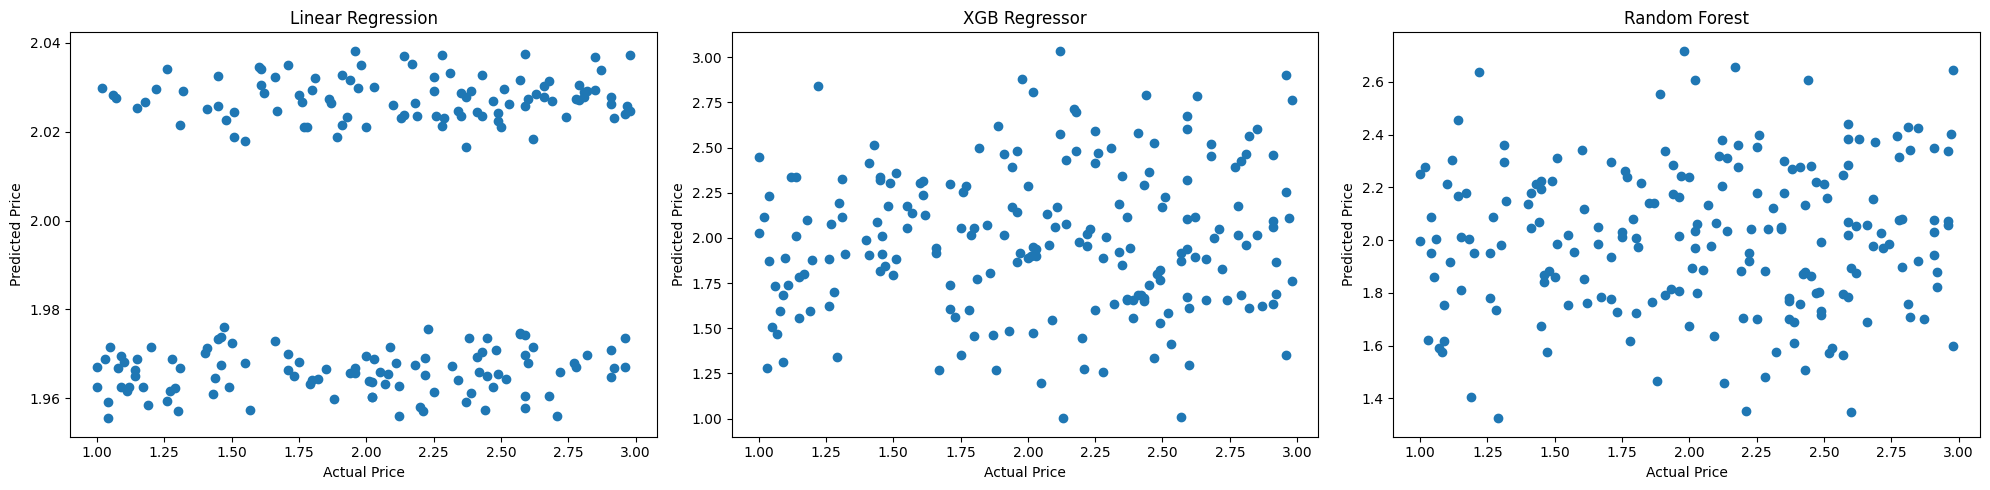

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, linear_regression_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression')

plt.subplot(1, 3, 2)
plt.scatter(y_test, xgb_regressor_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGB Regressor')

plt.subplot(1, 3, 3)
plt.scatter(y_test, random_forest_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest')

plt.tight_layout()
plt.show()

In [58]:
from keras.models import Sequential
from keras.layers import Dense

keras_model = Sequential()

keras_model.add(Dense(5, input_dim=5, activation='relu'))
keras_model.add(Dense(5, activation='relu'))
keras_model.add(Dense(1, activation='linear'))

keras_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
keras_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)
keras_predict = keras_model.predict(X_test)

Epoch 1/100
80/80 [==============================] - 1s 1ms/step - loss: 18752.6504 - mean_squared_error: 18752.6523
Epoch 2/100
80/80 [==============================] - 0s 1ms/step - loss: 8267.2217 - mean_squared_error: 8267.2217
Epoch 3/100
80/80 [==============================] - 0s 1ms/step - loss: 4204.4878 - mean_squared_error: 4204.4878
Epoch 4/100
80/80 [==============================] - 0s 1ms/step - loss: 2282.8301 - mean_squared_error: 2282.8301
Epoch 5/100
80/80 [==============================] - 0s 1ms/step - loss: 1252.2423 - mean_squared_error: 1252.2423
Epoch 6/100
80/80 [==============================] - 0s 1ms/step - loss: 666.0176 - mean_squared_error: 666.0176
Epoch 7/100
80/80 [==============================] - 0s 1ms/step - loss: 334.3515 - mean_squared_error: 334.3515
Epoch 8/100
80/80 [==============================] - 0s 1ms/step - loss: 154.5453 - mean_squared_error: 154.5453
Epoch 9/100
80/80 [==============================] - 0s 1ms/step - loss: 65.1834 - m

In [59]:
print('Keras RMSE: %.2f' % mean_squared_error(y_test, keras_predict, squared=True))

Keras RMSE: 0.71


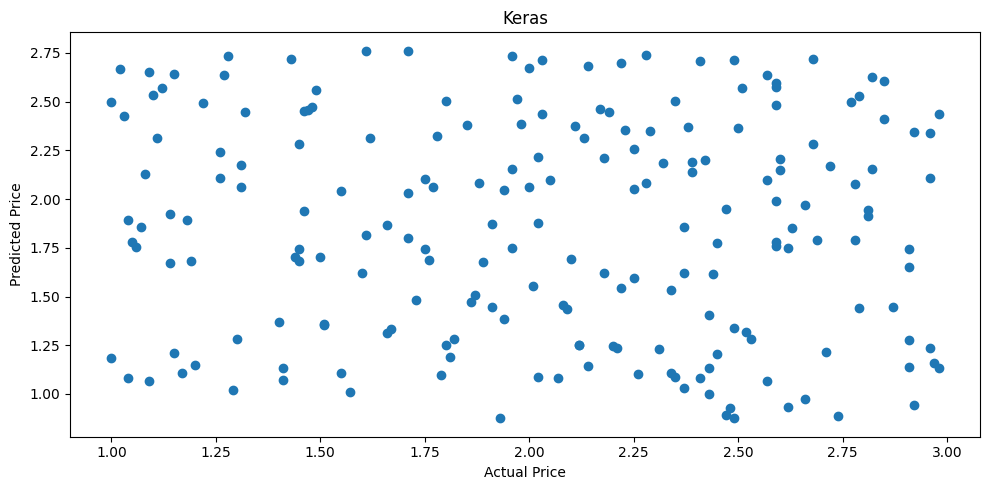

In [61]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, keras_predict)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Keras')
plt.tight_layout()
plt.show()